In [14]:
import requests
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
print ("all imported")

all imported


In [15]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())
api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
query = 'french fries'
response = requests.get(api_url + query, headers={'X-Api-Key': 's9S3fiY9BWYZtpCebS71Rg==Qk1nbauJKhKE9k8R'})
if response.status_code == requests.codes.ok:
    print(response.text)
else:
    print("Error:", response.status_code, response.text)


2.15.0
/device:GPU:0
{"items": [{"name": "french fries", "calories": 312.5, "serving_size_g": 100.0, "fat_total_g": 14.4, "fat_saturated_g": 2.3, "protein_g": 3.4, "sodium_mg": 209, "potassium_mg": 123, "cholesterol_mg": 0, "carbohydrates_total_g": 42.1, "fiber_g": 3.8, "sugar_g": 0.3}]}


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
base_dir = '/content/drive/My Drive/DSCI - 6011 DEEP LEARNING PROJECT'

In [42]:
os.chdir(base_dir)

### Working on the whole data with 101 classes takes a lot of time and computation, so we have decided to work with a total of 10 categories

In [43]:
def get_data_extract():
  # if "food-101" in os.listdir():
  #   print("Dataset already exists")
  # else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    print("Extraction done!")

In [44]:
# Check the extracted dataset folder
!ls

apple_pie	baklava		beef_tartare  beignets	meta	  pizza
baby_back_ribs	beef_carpaccio	beet_salad    bibimbap	omelette


In [45]:
os.listdir()

['pizza',
 'omelette',
 'bibimbap',
 'beignets',
 'beet_salad',
 'beef_tartare',
 'beef_carpaccio',
 'baklava',
 'baby_back_ribs',
 'apple_pie',
 'meta']

In [46]:
os.listdir('meta')

['train.txt',
 'train.json',
 'labels.txt',
 'test.txt',
 'classes.txt',
 'test.json']

In [47]:
!head meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [48]:
!head meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

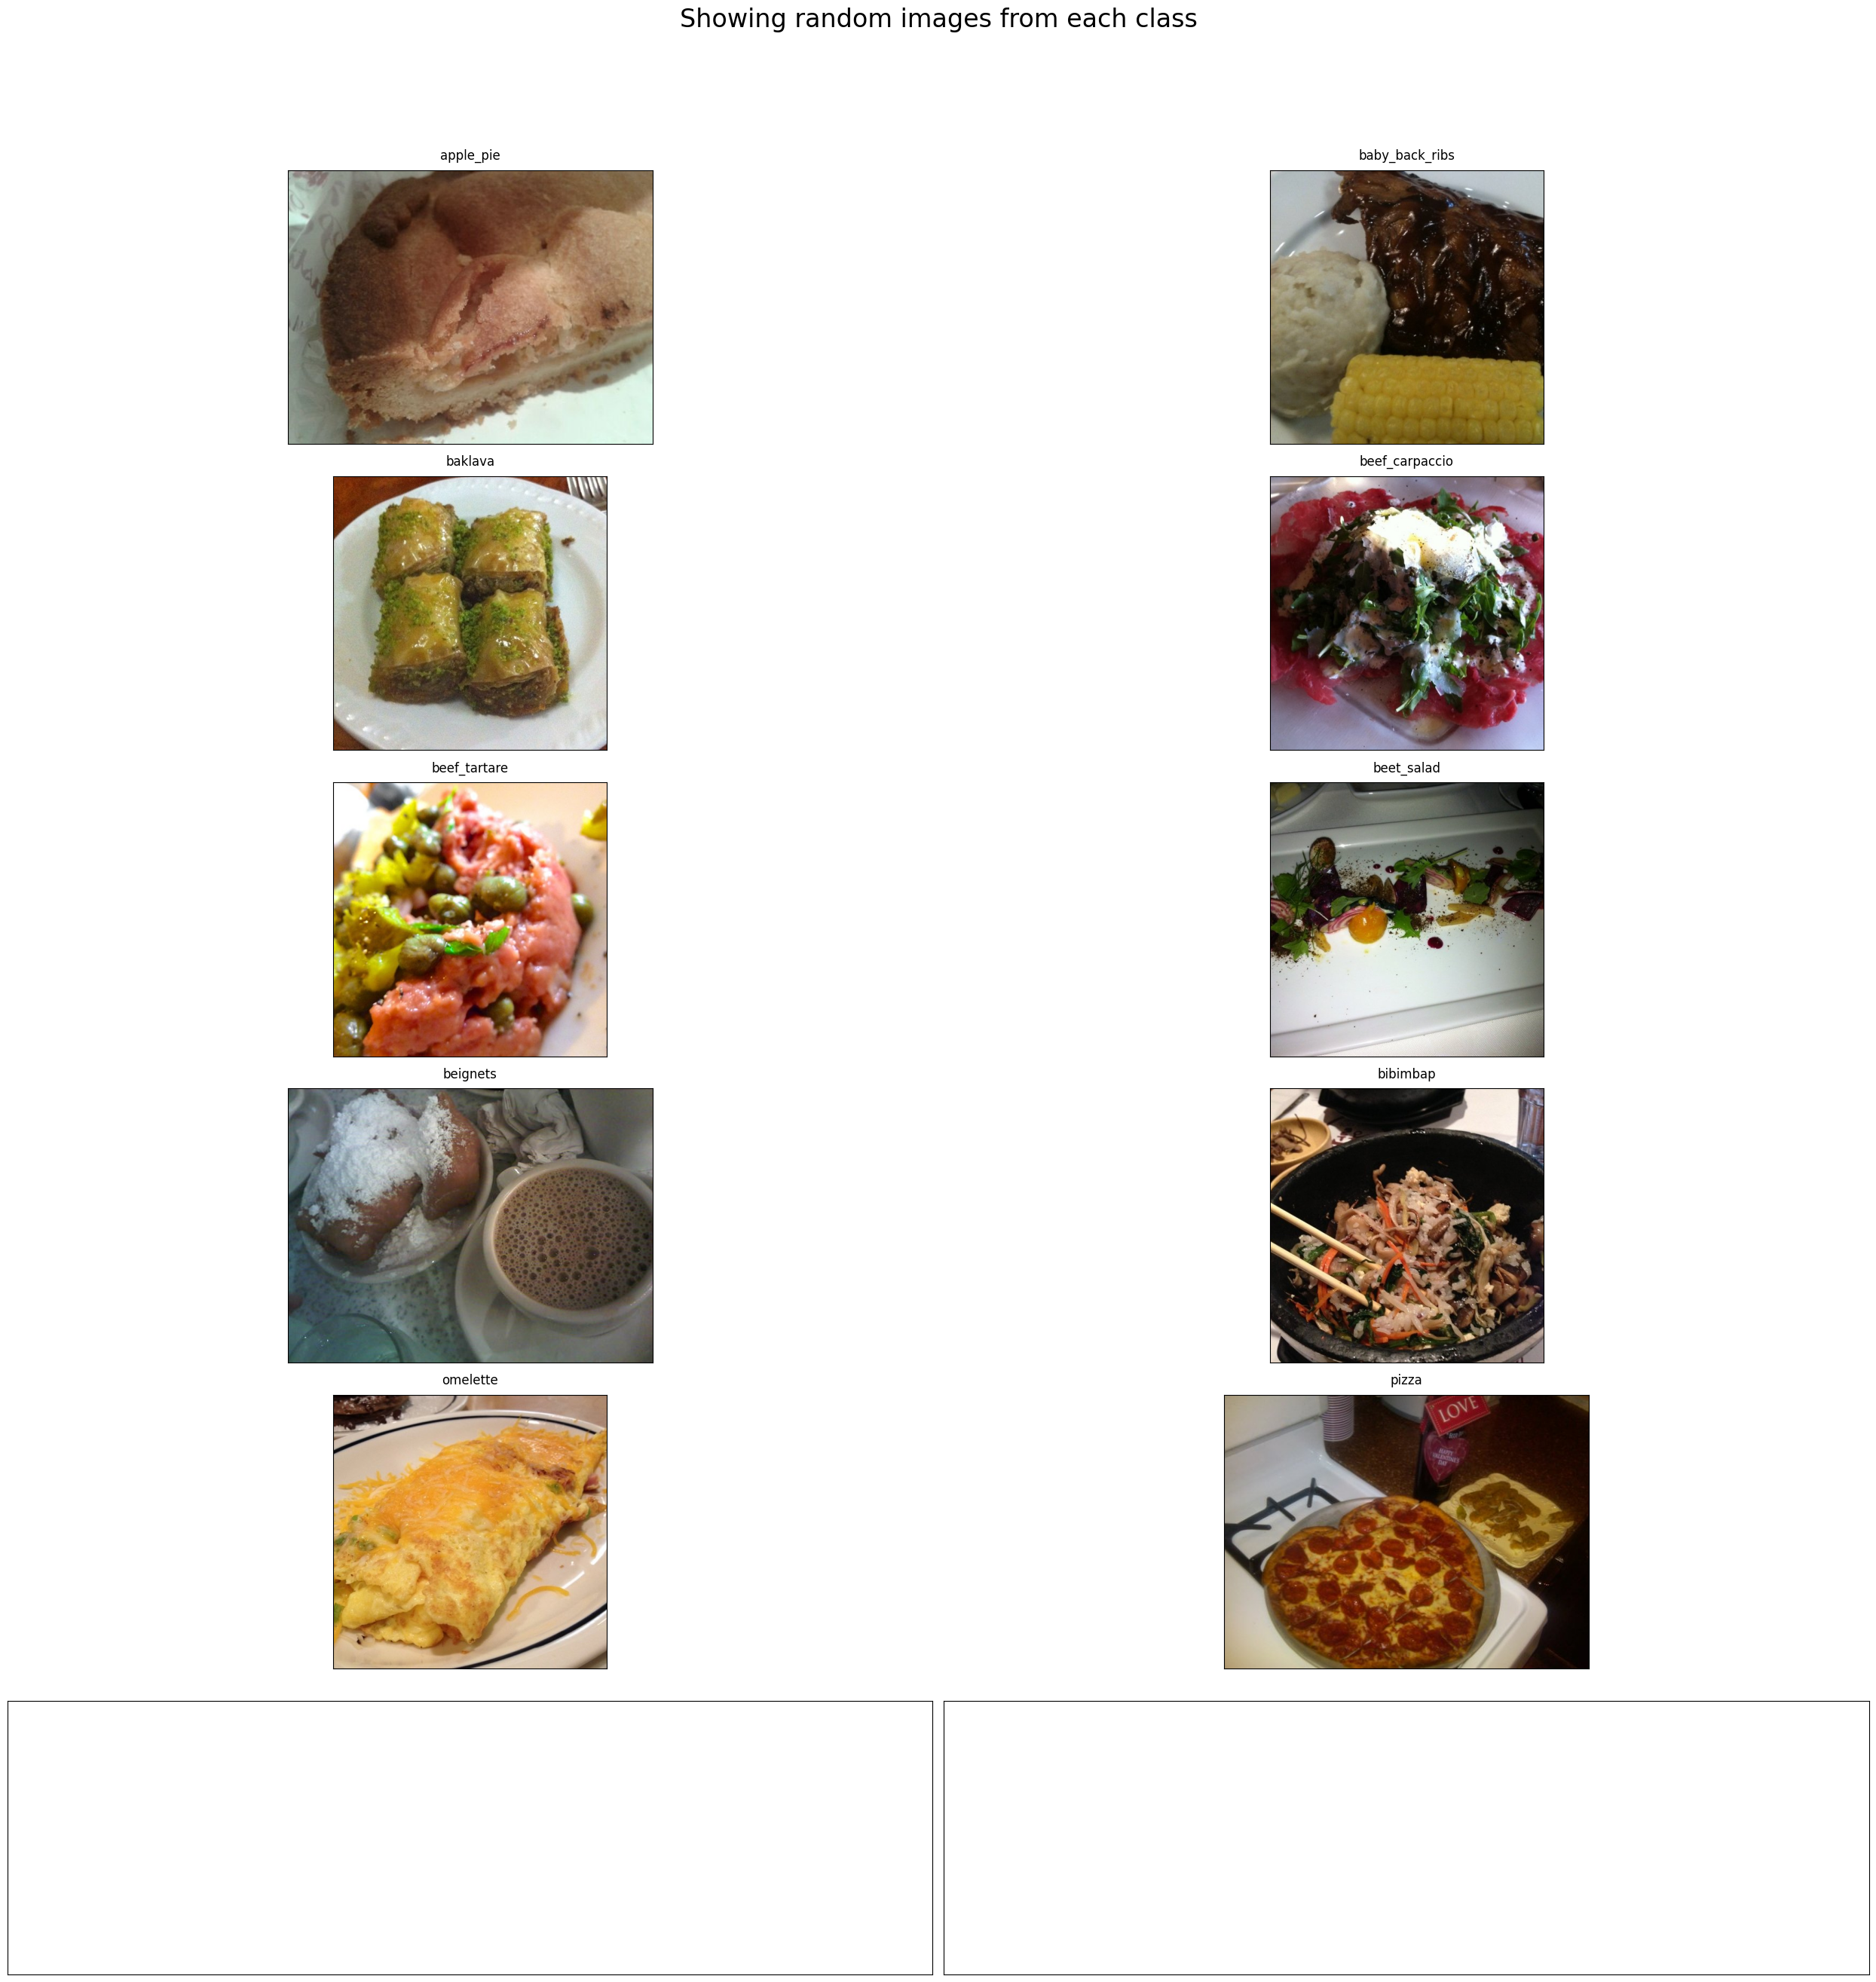

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt

rows = 6
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
fig.suptitle("Showing random images from each class", y=1.05, fontsize=24)
data_dir = os.path.join(base_dir, 'images/')
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id]
            food_id += 1
        except:
            break
        if food_selected == '.DS_Store':
            continue
        food_images_path = os.path.join(data_dir, food_selected)
        food_selected_images = os.listdir(food_images_path)
        if len(food_selected_images) > 0:  # Check if the list is empty
            food_selected_random = np.random.choice(food_selected_images)
            img = plt.imread(os.path.join(food_images_path, food_selected_random))
            ax[i][j].imshow(img)
            ax[i][j].set_title(food_selected, pad=10)
        else:
            ax[i][j].axis('off')

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

### **Split the image data into train and test using train.txt and test.txt**

In [54]:
import os
from shutil import copy
from collections import defaultdict

def prepare_data(filepath, src, dest, included_classes=None):
    # Create a dictionary to hold the list of images for each food class
    classes_images = defaultdict(list)

    # Ensure included_classes is a set if provided, otherwise, it remains None
    if included_classes is not None:
        included_classes = set(included_classes)

    # Read the file containing paths
    with open(filepath, 'r') as txt:
        paths = [line.strip() for line in txt.readlines()]
        for path in paths:
            components = path.split('/')
            food_class = components[0]
            image_name = components[1] + '.jpg'
            if included_classes is None or food_class in included_classes:
                classes_images[food_class].append(image_name)

    # Copy images into corresponding class directories
    for food_class, images in classes_images.items():
        if included_classes is None or food_class in included_classes:
            print("\nCopying images into ", food_class)
            class_path = os.path.join(dest, food_class)
            if not os.path.exists(class_path):
                os.makedirs(class_path)
            for image in images:
                source_path = os.path.join(src, food_class, image)
                destination_path = os.path.join(class_path, image)
                copy(source_path, destination_path)

    print("Copying Done!")

In [57]:
# Prepare training dataset
print("Creating train data...")
included_list = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap','pizza','omelette']
prepare_data(os.path.join(base_dir, 'meta/train.txt'), os.path.join(base_dir, 'images/'), 'train', included_list)

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  omelette

Copying images into  pizza
Copying Done!


In [59]:
# Prepare test data
print("Creating test data...")
prepare_data(os.path.join(base_dir, 'meta/test.txt'), data_dir, 'test', included_list)

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  omelette

Copying images into  pizza
Copying Done!


In [60]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
7500


In [61]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
2500


### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

In [62]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [63]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'omelette',
 'pizza']

In [64]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [65]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [66]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [67]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [68]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [69]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### InceptionV3 architecture model

In [70]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 [==============================] - 3s 0us/step


<ipython-input-70-b760b0c61731>:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.7404
Epoch 1: val_loss improved from inf to 1.97035, saving model to best_model_3class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 116s 596ms/step - loss: 0.6580 - accuracy: 0.7404 - val_loss: 1.9704 - val_accuracy: 0.5829
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.8214
Epoch 2: val_loss improved from 1.97035 to 0.81556, saving model to best_model_3class.hdf5
140/140 [==============================] - 72s 514ms/step - loss: 0.4771 - accuracy: 0.8214 - val_loss: 0.8156 - val_accuracy: 0.6236
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.8644
Epoch 3: val_loss improved from 0.81556 to 0.51433, saving model to best_model_3class.hdf5
140/140 [==============================] - 75s 532ms/step - loss: 0.3723 - accuracy: 0.8644 - val_loss: 0.5143 - val_accuracy: 0.8166
Epoch 4/30
140/140 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8765
Epoch 4: val_loss did not improve from 0.51433
140/140 [==============================] - 72s 510ms/step - loss: 0.3581 - accur

In [71]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

### **Loss and Accuracy Plots**

In [72]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(history.history['accuracy'])   # Updated key
    plt.plot(history.history['val_accuracy'])  # Updated key
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
    plt.grid(True)
    plt.show()

def plot_loss(history, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
    plt.grid(True)
    plt.show()


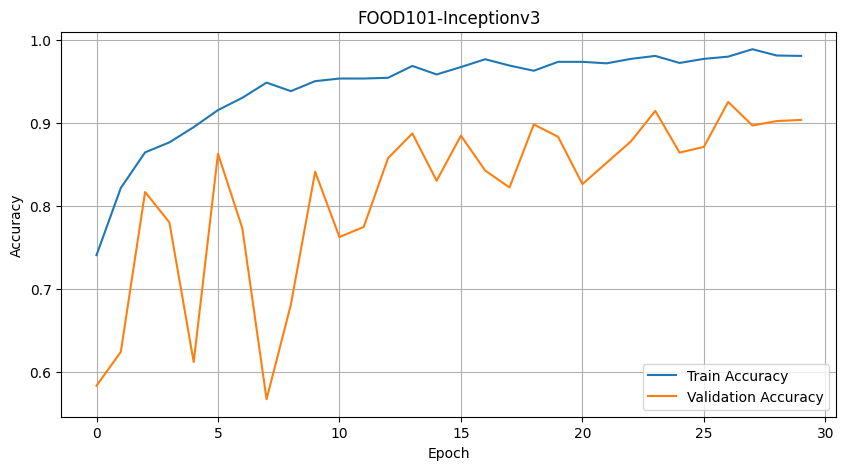

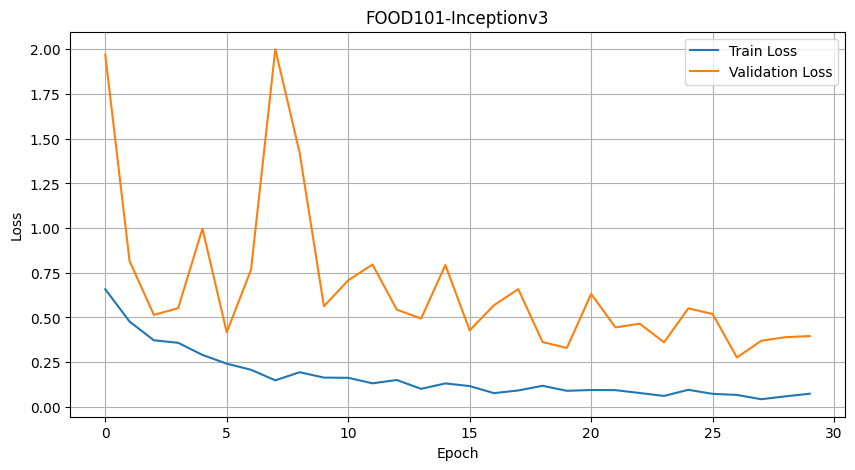

In [73]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

### **Using the best trained model to classify new images**

In [74]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 3.17 s, sys: 213 ms, total: 3.38 s
Wall time: 5.92 s


In [75]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
        print(pred_value)

    api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
    query = pred_value.replace("_"," ")
    response = requests.get(api_url + query, headers={'X-Api-Key': 's9S3fiY9BWYZtpCebS71Rg==Qk1nbauJKhKE9k8R'})
    if response.status_code == requests.codes.ok:
        print(response.text)
    else:
        print("Error:", response.status_code, response.text)



In [76]:
# Downloading images from internet using the URLs
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg


--2024-04-22 05:10:01--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K   374KB/s    in 0.3s    

2024-04-22 05:10:02 (374 KB/s) - ‘applepie.jpg’ saved [114276/114276]



1/1 [==============================] - 3s 3s/step


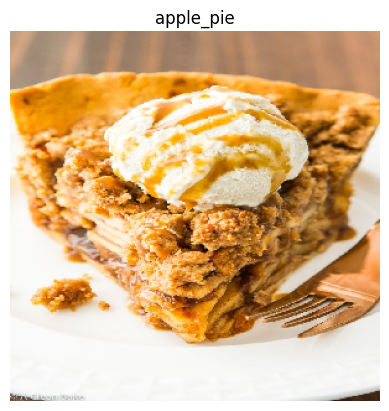

apple_pie
{"items": [{"name": "apple pie", "calories": 240.1, "serving_size_g": 100.0, "fat_total_g": 11.0, "fat_saturated_g": 3.8, "protein_g": 1.9, "sodium_mg": 200, "potassium_mg": 24, "cholesterol_mg": 0, "carbohydrates_total_g": 33.7, "fiber_g": 1.6, "sugar_g": 15.5}]}


In [77]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
predict_class(model_best, images, True)

#### The model has correctly predicted the image

## The model was trained on 3 samples. Let us mnow try 4 classes


In [78]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list


In [79]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 4
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'pizza']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'pizza']


In [80]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into pizza


In [81]:
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
3000


In [82]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into pizza


In [83]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
1000


In [86]:
# Let's use a pretrained Inceptionv3 model on subset of data with 4 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_4class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_4class.log')

history_4class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_4class.hdf5')


Found 3000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


<ipython-input-86-f774517692ae>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_4class = model.fit_generator(train_generator,


Epoch 1/30
188/515 [=========>....................] - ETA: 2:31 - loss: 0.6474 - accuracy: 0.7763


Epoch 1: val_loss improved from inf to 0.66095, saving model to best_model_4class.hdf5
515/515 [==============================] - 118s 192ms/step - loss: 0.6474 - accuracy: 0.7763 - val_loss: 0.6609 - val_accuracy: 0.7740


In [87]:
class_map_4 = train_generator.class_indices
class_map_4

{'apple_pie': 0, 'beef_carpaccio': 1, 'bibimbap': 2, 'pizza': 3}

In [90]:
# Downloading images from internet using the URLs
!wget -O fries.jpg https://wallpapercave.com/wp/wp3031767.jpg
!wget -O springrolls.jpg https://howtofeedaloon.com/wp-content/uploads/2016/02/bibimbap-1.jpg
!wget -O pizza.jpg https://i.pinimg.com/originals/43/0f/83/430f83bfa304c69f4f6c96abbb38223e.jpg
!wget -O garlicbread.jpg https://tableagent.s3.amazonaws.com/media/crumbs/xl/229_93.jpg

--2024-04-22 05:24:02--  https://wallpapercave.com/wp/wp3031767.jpg
Resolving wallpapercave.com (wallpapercave.com)... 104.22.52.71, 104.22.53.71, 172.67.29.26, ...
Connecting to wallpapercave.com (wallpapercave.com)|104.22.52.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193502 (189K) [image/jpeg]
Saving to: ‘fries.jpg’

fries.jpg           100%[===================>] 188.97K   980KB/s    in 0.2s    

2024-04-22 05:24:02 (980 KB/s) - ‘fries.jpg’ saved [193502/193502]

--2024-04-22 05:24:03--  https://howtofeedaloon.com/wp-content/uploads/2016/02/bibimbap-1.jpg
Resolving howtofeedaloon.com (howtofeedaloon.com)... 104.18.4.29, 104.18.5.29, 2606:4700::6812:51d, ...
Connecting to howtofeedaloon.com (howtofeedaloon.com)|104.18.4.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157759 (154K) [image/jpeg]
Saving to: ‘springrolls.jpg’

springrolls.jpg     100%[===================>] 154.06K  --.-KB/s    in 0.01s   

2024-04-22 05:24:03 

1/1 [==============================] - 1s 664ms/step


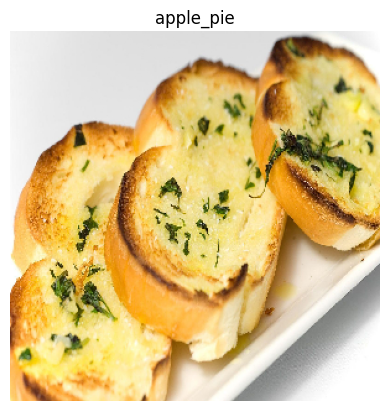

apple_pie
{"items": [{"name": "apple pie", "calories": 240.1, "serving_size_g": 100.0, "fat_total_g": 11.0, "fat_saturated_g": 3.8, "protein_g": 1.9, "sodium_mg": 200, "potassium_mg": 24, "cholesterol_mg": 0, "carbohydrates_total_g": 33.7, "fiber_g": 1.6, "sugar_g": 15.5}]}
1/1 [==============================] - 0s 29ms/step


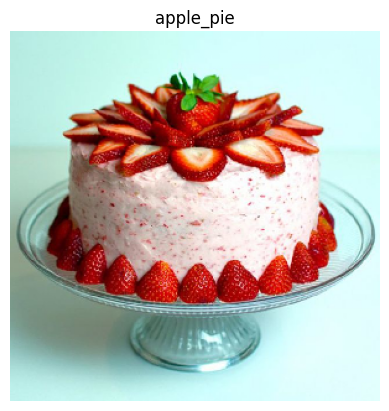

apple_pie
{"items": [{"name": "apple pie", "calories": 240.1, "serving_size_g": 100.0, "fat_total_g": 11.0, "fat_saturated_g": 3.8, "protein_g": 1.9, "sodium_mg": 200, "potassium_mg": 24, "cholesterol_mg": 0, "carbohydrates_total_g": 33.7, "fiber_g": 1.6, "sugar_g": 15.5}]}
1/1 [==============================] - 0s 28ms/step


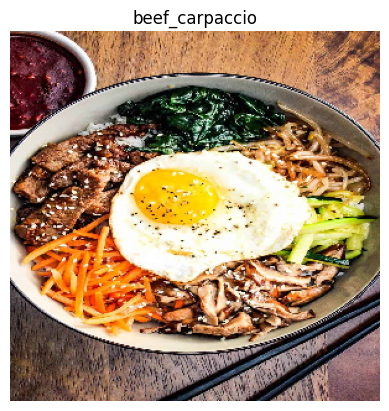

beef_carpaccio
{"items": [{"name": "beef", "calories": 291.9, "serving_size_g": 100.0, "fat_total_g": 19.7, "fat_saturated_g": 7.8, "protein_g": 26.6, "sodium_mg": 63, "potassium_mg": 206, "cholesterol_mg": 87, "carbohydrates_total_g": 0.0, "fiber_g": 0.0, "sugar_g": 0.0}, {"name": "carpaccio", "calories": 232.2, "serving_size_g": 100.0, "fat_total_g": 16.9, "fat_saturated_g": 7.5, "protein_g": 16.8, "sodium_mg": 338, "potassium_mg": 191, "cholesterol_mg": 69, "carbohydrates_total_g": 2.6, "fiber_g": 0.3, "sugar_g": 0.9}]}
1/1 [==============================] - 0s 39ms/step


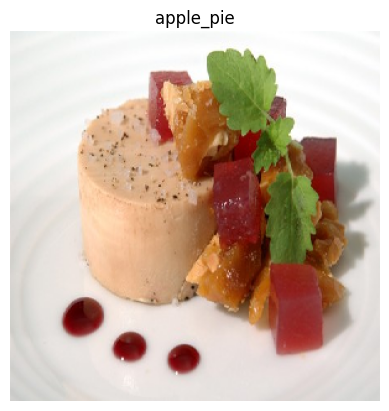

apple_pie
{"items": [{"name": "apple pie", "calories": 240.1, "serving_size_g": 100.0, "fat_total_g": 11.0, "fat_saturated_g": 3.8, "protein_g": 1.9, "sodium_mg": 200, "potassium_mg": 24, "cholesterol_mg": 0, "carbohydrates_total_g": 33.7, "fiber_g": 1.6, "sugar_g": 15.5}]}
Current date and time: 2024-04-22 05:24:19.043465


In [91]:
# Make a list of downloaded images and test the trained model
images = []
images.append('fries.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

from datetime import datetime

# Get the current date and time
now = datetime.now()

# Print the current date and time
print("Current date and time:", now)

#### The model continued doing well in identifying the images

In [92]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Print the current date and time
print("Current date and time:", now)


Current date and time: 2024-04-22 05:25:04.776038


### **Model Summary**

* **Load the saved model and a test image**

In [93]:
# Load the saved model trained with 3 classes
K.clear_session()
print("Loading the model..")
model = load_model('best_model_3class.hdf5',compile = False)

Loading the model..


* **Summary of the model gives us the list of all the layers in the network along with other useful details**

In [94]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [95]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
class_labels = list(validation_generator.class_indices.keys())
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# Predict and evaluate again
pred = model.predict_generator(validation_generator, steps=(nb_validation_samples // batch_size))
predicted_classes = np.argmax(pred, axis=1)
report = classification_report(validation_generator.classes, predicted_classes, target_names=class_labels)
print(report)


<ipython-input-95-7e71a69f45b6>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(validation_generator, steps=(nb_validation_samples // batch_size))


                precision    recall  f1-score   support

     apple_pie       0.28      0.42      0.34       250
beef_carpaccio       0.26      0.33      0.29       250
      bibimbap       0.24      0.30      0.27       250
         pizza       0.00      0.00      0.00       250

      accuracy                           0.26      1000
     macro avg       0.20      0.26      0.23      1000
  weighted avg       0.20      0.26      0.23      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
